# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib, seaborn as sns, astropy.units as u

from astropy.io import votable, ascii
from astropy.coordinates import SkyCoord
from gdpyc.core import GasMap, DustMap
from scipy import interpolate, stats

from code.utilities import custom_iter, split_filters, new_since_Fong, literature_references
from code.xrt import XRT_lightcurve, get_photonIndex, get_columnDensity
from code.uncertainty import AsymmetricUncertainty, UncertaintyArray
from code.fluxtools import effective_wavelength, lightcurve, simulate_spectrum

#calc_code = importlib.import_module("legacy.Calculation Code.calc_beta_ox")
#graph_code = importlib.import_module("legacy.Graphing Code.Graphing_Beta_OX")

alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
alpha += alpha.lower()
numeric = ".0123456789"
UVOT_conversions = {'V': -0.01, 'B': -0.13, 'U': 1.02, 'UVW1': 1.51, 'UVM2': 1.69, 'UVW2': 1.73, 'White': 0.8}

In [3]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce/flatten MultiIndex
for grb in swift[swift["TriggerNumber"].apply(pd.to_numeric,errors="coerce").isna()]["GRB"]: # non-Swift bursts
    bat_data = pd.read_html(f"https://swift.gsfc.nasa.gov/archive/grb_table/fullview/{grb}/")[0]
    T90 = bat_data.loc[bat_data[0]=="T90: c",1].values # get the T90 anyway, if it exists
    swift.loc[swift["GRB"]==grb,"BAT T90[sec]"] = pd.to_numeric(T90, errors="coerce")

In [4]:
valid = ['050509B', '050724', '051103', '051105', '051114', '051211A', '051221', '060427B',
         '060429', '060502B', '070124', '070201', '070429B', '070714B', '070810B', '071112B',
         '080905', '080913', '081211B', '081216', '081223', '090531B', '090715A', '090916A',
         '090927A', '091117A', '091126B', '100213A', '100216A', '100816A', '110402A', '110802A',
         '120811B', '120830A', '140428B', '140604A', '150118C', '150424A', '150906B', '150922A',
         '151221A', '160111A', '160219A', '160406A', '160620A', '160709A', '160820A', '160822A',
         '160825A', '160829A', '161004A', '170127C', '170206A', '170219A', '170220A', '170222A',
         '170403A', '170616A', '170708A', '170728B', '170805A', '170805B', '170816A', '170817A',
         '170822A', '170825A', '170826A', '170827A', '170827B', '170921B', '171030A', '171103A',
         '171106A', '171223A', '180317A', '180418A', '180529A', '180618A', '180626C', '180715B',
         '180716A', '180728B', '180824A', '181121A', '181126B', '181222B', '181225A', '190121A',
         '190206A', '190331C', '190606A', '190626B', '190630A', '190719C', '190724A', '190810A',
         '190813A', '190830B', '190831B', '190903A', '190913A', '191017C', '191101B', '191116A',
         '191203A', '191221A', '200103A', '200128A', '200128B', '200129A', '200212A', '200219A',
         '200221A', '200224C', '200306B', '200307A', '200308A', '200313B', '200325A', '200327A',
         '200401A', '200405B', '200420A', '200423A', '200501A', '200506B', '200509B', '200514B',
         '200521A', '200605A', '200623B', '200626A', '200703A', '200706A', '200710A', '200714B',
         '200716C', '200718A', '200805A', '200815A', '200817A', '200824A', '200826A', '200903C',
         '200907A', '200908A', '200916B', '200920A', '200920B', '200923A', '200928A', '201103A',
         '201108A', '201109A', '201111A', '201130A', '201214B', '201221B', '201222A', '201227A',
         '210124B', '210205B', '210307B', '210326A', '210410A', '210421C', '210424B', '210425A',
         '210506A', '210510A', '210529A', '210529B', '210601A', '210605A'] # flagged from GCN Circulars

valid += ['050202', '050509B', '050709', '050724A', '050813', '050906', '050925',
          '051210', '051221A', '060121', '060313', '060502B', '060801', '061006',
          '061201', '061210', '061217', '070209', '070406', '070429B', '070707',
          '070714B', '070724A', '070729', '070809', '070810B', '071017', '071112B',
          '071227', '080121', '080123', '080426', '080503', '080702A', '080905A',
          '080919', '081024A', '081024B', '081226A', '081226B', '090305', '090305A',
          '090426', '090426A', '090510', '090515', '090607', '090621B', '090916',
          '091109B', '091117', '100117A', '100206A', '100213', '100625A', '100628A',
          '100702A', '101219A', '101224A', '110112A', '110112B', '110420B', '111020A',
          '111117A', '111121A', '111222A', '120229A', '120305A', '120521A', '120630A',
          '120804A', '120817B', '121226A', '130313A', '130515A', '130603B', '130626A',
          '130716A', '130822A', '130912A', '131004A', '131125A', '131126A', '131224A',
          '140129B', '140320A', '140402A', '140414A', '140516A', '140606A', '140619B',
          '140622A', '140903A', '140930B', '141202A', '141205A', '141212A', '150101A',
          '150101B', '150120A', '150301A'] # Fong, et al.

valid += ['130313A', '130822A', '130912A', '140903A', '141212A', '150120A', '150423A',
          '150831A', '160303A', '160408A', '160410A', '160411A', '160601A', '160612A',
          '160624A', '161001A', '170112A', '170127B', '170428A', '170524A', '180715A',
          '180718A', '180727A', '180805B', '181126A', '190427A', '191031D', '200623A',
          '201221D'] # Rastinejad, et al.

In [5]:
sGRBs = swift[(swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2) | swift["GRB"].isin(valid)].copy() # filter catalog for GRBs with a valid T90 that is <2s

### Data parsing and cleanup

In [6]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
            'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
            'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
            'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)',
            'BAT Photon Index90% Error(15-150 keV)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
            'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
            'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
            'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]','XRT InitialTemporalIndex':"α",
                      'XRTSpectral Index(Gamma)':'Γ','UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters',"XRT RA(J2000)":"RA","XRT Dec(J2000)":"Dec"},inplace=True)

mags = pd.Series([],dtype=float) # numerical magnitudes
lims = pd.Series([],dtype=object) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in numeric]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in numeric]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

See GCN 10184


In [7]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()

error 214; error 304; error 316; error 382; error 432; error 611; error 652; error 700; error 729; error 811; error 944; error 1137; error 1139; error 1154; error 1206; error 1220; error 1373; error 1565; 

<ipython-input-7-9935b0563a4e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()


In [8]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [9]:
#sGRBs.to_csv("./products/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,TriggerNumber,BAT T90[sec],RA,Dec,XRT dt [sec],α,Γ,UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
0,210919A,1073893,0.16,05:21:01.05,01:18:42.1,97.02,NaN,1.88797,100,V>18.7,"{'B': '19.3', 'U': '19.8', 'UVM2': '19.0', 'UV...","CAHA (2.2m), OSN (1.5m)",NaN,18.7,brightest
14,210726A,1061687,0.39,12:53:09.80,19:11:24.7,59.97,-0.7399,2.24209,276,NaN,{'idx': 14},"Fermi (GBM), Chandra, VLA @ 6 & 10 GHz",NaN,NaN,equal
47,210413B,1043009,1.088,NaN,NaN,NaN,NaN,NaN,185000,NaN,{'idx': 47},NaN,NaN,NaN,equal
49,210410A,1042113,52.88,17:59:01.05,45:21:42.9,61,-3.372,1.43013,1113,V>17.0,"{'B': '19.7', 'U': '19.9', 'UVM2': '19.4', 'UV...","Fermi (GBM & LAT), Ondrejov D50, AGILE, HJT (1...",NaN,17.0,brightest
53,210323A,1038247,1.12,21:11:47.20,25:22:09.5,85.20,-1.687,1.72358,89,V>17.7,"{'B': '19.3', 'U': '19.3', 'UVM2': '18.8', 'UV...","NOT, AZT-33IK (Mondy), Fermi (GBM), Konus-Wind...",NaN,17.7,brightest


### Legacy and new data imports

In [10]:
BetaXData = pd.read_csv("./data/BetaXData.csv", header=None, names=["GRB","Beta_X","Beta_X_pos","Beta_X_neg"])
BetaXData["GRB"] = [entry.split("-")[-1] for entry in BetaXData["GRB"]]
BetaXData["Beta_X"] *= -1

OpticalData = pd.read_csv("./data/OpticalData.csv", header=None, names=["GRB","Time","Observatory","Instrument","Filter","Exposure","F_o","e_F_o"])
OpticalData["GRB"] = [entry.split("-")[-1] for entry in OpticalData["GRB"]]
OpticalData["Time"] *= 60*60

filters = pd.read_csv("./data/FilterInfo.csv", header=None, names=["Observatory","Instrument","Filter","Wavelength","Frequency"])
OpticalData = OpticalData.merge(filters,how="left",on=["Observatory","Instrument","Filter"])

XRayData = pd.read_csv("./data/XRayData.csv", header=None, names=["GRB","Time","Exposure","F_x","e_F_x"])

In [14]:
new_sGRBs = new_since_Fong(sGRBs) # Fong et al. (2015) has data up to March 2015, i.e. GRB 150301A

In [15]:
new_sGRBs

,GRB,TriggerNumber,RA,Dec,BAT T90[sec],XRT dt [sec],α,Γ,UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim,Beta_X,Beta_X_neg,Beta_X_pos
0,210726A,1061687,12:53:09.80,19:11:24.7,0.39,59.97,-0.7399,2.24209,276.0,NaN,{'idx': 11},"Fermi (GBM), Chandra, VLA @ 6 & 10 GHz",NaN,NaN,equal,1.20,0.30,0.30
1,210413B,1043009,NaN,NaN,1.088,NaN,NaN,NaN,185000.0,NaN,{'idx': 44},NaN,NaN,NaN,equal,NaN,NaN,NaN
2,210410A,1042113,17:59:01.05,45:21:42.9,52.88,61.00,-3.372,1.43013,1113.0,V>17.0,"{'B': '19.7', 'U': '19.9', 'UVM2': '19.4', 'UV...","Fermi (GBM & LAT), Ondrejov D50, AGILE, HJT (1...",NaN,17.0,brightest,0.43,0.16,0.18
3,210323A,1038247,21:11:47.20,25:22:09.5,1.12,85.20,-1.687,1.72358,89.0,V>17.7,"{'B': '19.3', 'U': '19.3', 'UVM2': '18.8', 'UV...","NOT, AZT-33IK (Mondy), Fermi (GBM), Konus-Wind...",NaN,17.7,brightest,0.72,0.19,0.20
4,210119A,1017711,NaN,NaN,0.06,NaN,NaN,NaN,NaN,NaN,{'idx': 70},"Fermi (GBM), MASTER-OAFA, Insight-HXMT/HE, GEC...",NaN,NaN,equal,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,150831A,653838,14:44:05.81,-25:38:05.8,1.15,83.44,-2.511,1.63580,88.0,V>19.8,"{'B': '20.4', 'U': '21.0', 'UVM2': '21.3', 'UV...","INTEGRAL, Konus-Wind",NaN,19.8,brightest,0.80,0.40,0.50
65,150728A,650617,19:28:54.89,33:54:57.7,0.83,70.20,-0.4,NaN,75.0,V>19.8,"{'B': '21.1', 'U': '21.0', 'UVM2': '20.2', 'UV...",NaN,NaN,19.8,brightest,1.70,2.80,3.80
66,150710A,648437,12:57:52.91,14:19:05.0,0.15,49.20,NaN,NaN,53.0,V>18.1,"{'B': '19.1', 'U': '20.0', 'UVM2': '18.2', 'UV...",Konus-Wind,NaN,18.1,brightest,NaN,NaN,NaN
67,150424A,638946,10:09:13.35,-26:37:51.3,91,87.87,-1.121,1.98937,99.0,V>19.8,"{'B': '20.71', 'U': '20.13', 'UVM2': '19.91', ...","Keck I (10m), Konus-Wind, NOT, MPG (2.2m), GTC...",<3 (GTC),19.8,brightest,1.02,0.17,0.18


## X-ray

### Swift XRT light curves and spectra

In [16]:
burst = "160624A"
fluxdata = XRT_lightcurve(burst,swift)
Gamma = get_photonIndex(burst,swift)
NH = get_columnDensity(burst,swift)

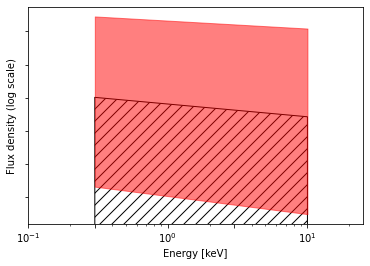

In [17]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma.value-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma.maximum-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma.minimum-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
#plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density (log scale)")
plt.show()

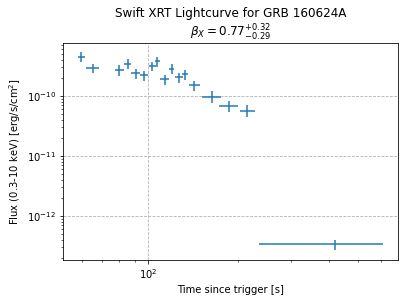

In [18]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X = %.2f_{-%.2f}^{+%.2f}$" % (burst,Gamma-1.,Gamma.minus,Gamma.plus))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")

plt.show()

In [219]:
xrt_data = pd.read_csv("./products/Swift_XRT_lightcurves.csv")
# xrt_data = pd.DataFrame(columns=['Time', 'Tpos', 'Tneg', 'Flux', 'Fluxpos', 'Fluxneg', 'GRB'])
# for i in sGRBs.index:
#     GRB_ID = sGRBs.loc[i,"GRB"]
#     print(GRB_ID,end=": ")
#     try:
#         Gamma = get_photonIndex(GRB_ID,swift)
#         sGRBs.loc[i,"Beta_X"] = Gamma.value - 1
#         sGRBs.loc[i,"Beta_X_neg"] = Gamma.minus
#         sGRBs.loc[i,"Beta_X_pos"] = Gamma.plus
#         print("index ✓",end=", ")
#     except:
#         print("index ✗",end=", ")
#     print()    
#     try:
#         fluxdata = XRT_lightcurve(GRB_ID,swift)
#         xrt_data = xrt_data.append(fluxdata,ignore_index=True)
#         print("lightcurve ✓")
#     except:
#         print("lightcurve ✗")

### X-ray flux values to spectral flux density conversions

$$ F_\text{x} = \int_{0.3\text{ keV}}^{10\text{ keV}} F(E)\ dE = \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} F_\nu\ d\nu = A \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} \nu^{-\beta}\ d\nu $$
$$ F_\text{x} = \left.\begin{cases} A\frac{\nu^{1-\beta}}{1-\beta}, & \beta \neq 1 \\ A\ln(\nu), & \beta = 1 \end{cases}\right\}_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} $$

In [220]:
for i in xrt_data.index:
    grb_id = xrt_data.loc[i,"GRB"]
    if grb_id not in sGRBs["GRB"].values:
        continue
    beta = AsymmetricUncertainty(float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X"]),
                                 float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X_pos"]/1.645), # 90% conf to 1-sigma
                                 float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X_neg"]/1.645)) # 90% conf to 1-sigma
    B = beta.value
    Fx = AsymmetricUncertainty(xrt_data.loc[i,"Flux"], xrt_data.loc[i,"Fluxpos"], np.abs(xrt_data.loc[i,"Fluxneg"]))
    if B == 1:
        integral = np.log(10) - np.log(0.3)
    else:
        integral = (10**(1-B) - 0.3**(1-B))/(1-B)

    log_mean_energy = 10**np.mean((np.log10(0.3),np.log10(10))) # halfway between the endpoints in log space

    dfdF = (log_mean_energy**(-B))/integral
    dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*Fx.value/integral #- log_mean_energy**(-B)*(1-B)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-B)-0.3**(1-B))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-B)-0.3**(1-B))
    pos_err = np.sqrt(dfdF**2*Fx.plus**2 + dfdB**2*beta.plus**2)
    neg_err = np.sqrt(dfdF**2*Fx.minus**2 + dfdB**2*beta.minus**2)
    result = Fx.value*log_mean_energy**(-B)/integral
    spectral_flux = AsymmetricUncertainty(result,pos_err,neg_err) # erg/s/cm^2/keV
    spectral_flux *= 1e23/241797944177033445 # convert to Jy
    xrt_data.loc[i,"SpecFlux"] = spectral_flux

### Fong, et al. (2015)'s X-ray data

In [221]:
for grb_id in XRayData["GRB"].unique(): # add David's old data in the same format
    GRB = grb_id[3:]
    lightcurve = XRayData.loc[XRayData["GRB"]==grb_id,:]
    if GRB not in xrt_data["GRB"].tolist():
        for i in lightcurve.index:
            t = lightcurve.loc[i,"Time"]
            tpos = tneg = lightcurve.loc[i,"Exposure"]/2
            flux = lightcurve.loc[i,"F_x"]/1000000 # uJy to Jy
            if lightcurve.loc[i,"e_F_x"] != 0:
                fluxpos = fluxneg = lightcurve.loc[i,"e_F_x"]/1000000
            else:
                fluxpos = 0
                fluxneg = np.inf
            newrow = dict(zip(xrt_data.columns,
                              [GRB,t,tpos,tneg,np.nan,np.nan,np.nan,AsymmetricUncertainty(flux,fluxpos,fluxneg)]))
            xrt_data = xrt_data.append(newrow, ignore_index=True)
            
xrt_data.sort_values(by=["GRB","Time"], ascending=[False,True], inplace=True)

## Optical

### Load new optical data

In [222]:
new_optical = pd.read_excel("./data/newData.xlsx")

for col in ["GRB","TriggerNumber","Observatory","Instrument","Source","E(B-V)"]:
    for i in new_optical.index:
        if pd.isna(new_optical.loc[i,col]):
            new_optical.loc[i,col] = new_optical.loc[i-1,col] # deal with merged Excel cells
new_optical.drop(new_optical[new_optical["Magnitude"]=="spectroscopy only"].index,axis=0,inplace=True)

rastinejad = pd.read_csv("./data/Rastinejad_Table1.csv")
for i in rastinejad.index:
    info = {}
    info["GRB"] = rastinejad.loc[i,"GRB"]
    if "/" in rastinejad.loc[i,"Telescope/Instrument"]:
        info["Observatory"] = rastinejad.loc[i,"Telescope/Instrument"].split("/")[0]
        info["Instrument"] = rastinejad.loc[i,"Telescope/Instrument"].split("/")[1]
    else:
        info["Observatory"] = rastinejad.loc[i,"Telescope/Instrument"]
    info["Filter"] = rastinejad.loc[i,"Filter"]
    info["Time (s)"] = float(rastinejad.loc[i,"dt [sec]"])
    if ">" in rastinejad.loc[i,"Magnitude"]:
        info["Magnitude"] = float(rastinejad.loc[i,"Magnitude"].replace(">",""))
        info["Mag error"] = "3-sigma"
    elif "+/-" in rastinejad.loc[i,"Magnitude"]:
        info["Magnitude"] = float(rastinejad.loc[i,"Magnitude"].split(" +/- ")[0])
        info["Mag error"] = float(rastinejad.loc[i,"Magnitude"].split(" +/- ")[1])
    info["λ_eff"] = float(rastinejad.loc[i,"Wavelength"])
    info["Source"] = "Rastinejad"
    info["E(B-V)"] = float(rastinejad.loc[i,"E(B-V)"])
    new_optical = new_optical.append(info,ignore_index=True)

new_optical["mag_w_err"] = [AsymmetricUncertainty(mag,err,err) if isinstance(err,(float,int)) else AsymmetricUncertainty(mag,np.inf,0) for mag,err in new_optical[["Magnitude","Mag error"]].values]

c:\users\caden gobat\appdata\local\programs\python\python38\lib\site-packages\pandas\io\parsers.py:765: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


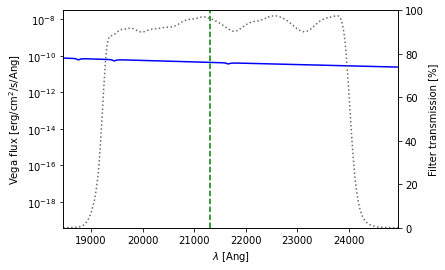

21303.69033401786

In [23]:
# I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt")
# rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
# rprime_filter.columns = ["Wavelength","Transmission"]
# rprime_filter["Wavelength"] *= 10
# MOSFIRE_J = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_J.txt",delimiter="   ").iloc[:,:2]
# MOSFIRE_J = MOSFIRE_J.rename(columns=dict(zip(MOSFIRE_J.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
# MOSFIRE_J["Wavelength"] *= 10000
# MOSFIRE_J["Transmission"] *= 100

MOSFIRE_K = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_K.txt",delimiter="   ").iloc[:,:2]
MOSFIRE_K = MOSFIRE_K.rename(columns=dict(zip(MOSFIRE_K.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
MOSFIRE_K["Wavelength"] *= 10000
MOSFIRE_K["Transmission"] *= 100
effective_wavelength(MOSFIRE_K,dl=5,show_plot=True)

### Extinction correction

$ A_b = R_b \cdot E_{B-V} $ for an arbitrary band $b$

In [24]:
RbTable = pd.read_csv("./data/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"]) # function that takes a wavelength [Ang] and returns the corresponding R_b value

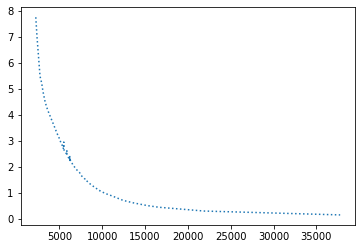

In [25]:
RbTable.sort_values(by="lambda_eff",inplace=True)
plt.plot(RbTable.lambda_eff, RbTable.R_b, ":")

### Optical magnitude to spectral flux density conversions

In [223]:
for i in new_optical.index:    
    try:
        new_optical.loc[i,"Extinction"] = Rb(new_optical.loc[i,"λ_eff"])*new_optical.loc[i,"E(B-V)"]
    except ValueError:
        pass

In [224]:
new_optical["Flux (Jy)"] = 3631*10**(-(new_optical["mag_w_err"]-new_optical["Extinction"])/2.5) # AB mag = 0 at f_nu = 3631 Jy

### Fong, et al. (2015)'s optical data

In [227]:
all_optical = new_optical.copy()

for i in OpticalData.index:
    GRB = OpticalData.loc[i,"GRB"]
    obs = OpticalData.loc[i,"Observatory"]
    inst = OpticalData.loc[i,"Instrument"]
    filt = OpticalData.loc[i,"Filter"]
    time = OpticalData.loc[i,"Time"]
    lambda_eff = OpticalData.loc[i,"Wavelength"]*10
    flux = OpticalData.loc[i,"F_o"]/1000000
    fluxpos = fluxneg = OpticalData.loc[i,"e_F_o"]/1000000
    if any([fluxpos == 0, fluxneg ==0]):
        fluxpos = 0
        fluxneg = np.inf
    newrow = dict(zip(all_optical.columns, [GRB,np.nan,obs,inst,filt,lambda_eff,time,np.nan,np.nan,"Fong",
                                            np.nan,np.nan,np.nan,AsymmetricUncertainty(flux,fluxpos,fluxneg)]))
    all_optical = all_optical.append(newrow, ignore_index=True)
    
all_optical.sort_values(by=["GRB","Time (s)"],ascending=[False,True],inplace=True)

## Information compilation

### Match data points in time

In [238]:
max_dt = 0.1 # allowable % time difference
nu_x = 10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18 # xray frequency [m]
results = pd.DataFrame(columns=["GRB","t_o","dt%","nu_o","F_o","nu_x","F_x","B_ox"])
for i_o in all_optical.index: # for each optical data point
    t_o = all_optical.loc[i_o,"Time (s)"] # optical observation time
    F_o = all_optical.loc[i_o,"Flux (Jy)"] # optical flux
    nu_o = 299792458/float(all_optical.loc[i_o,"λ_eff"]/1e10) # optical frequency [m]
    for i_x in xrt_data[xrt_data["GRB"]==all_optical.loc[i_o,"GRB"]].index: # for each x-ray data point on this GRB
        t_x = float(xrt_data.loc[i_x,"Time"]) # x-ray observation time
        dt = np.abs(t_o-t_x)/t_x # time difference
        if dt <= max_dt: # if time separation is allowable
            F_x = xrt_data.loc[i_x,"SpecFlux"]
            Beta_ox = -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)
            if pd.notna(Beta_ox.value):
                results = results.append({"GRB":all_optical.loc[i_o,"GRB"], "t_o":t_o, "dt%":dt,
                       "nu_o":nu_o, "F_o":F_o, "nu_x":nu_x, "F_x":F_x,
                       "B_ox":Beta_ox},ignore_index=True)
        else: # if data points don't match
            pass

### Incorporate error in $\beta_\text{ox}$ due to temoral separation ($\Delta\beta_\text{ox}$)

In [239]:
delta_B_ox = lambda dt, alpha=1 : np.abs(alpha*np.log10(1+dt)) # Fitzpatrick Eq. 41

for i in results.index:
    grb = results.loc[i,"GRB"]
    a = 1 #float(sGRBs.loc[sGRBs["GRB"]==grb, "α"])
    dt = results.loc[i,"dt%"]
    if pd.notna(a):
        results.loc[i,"B_ox"].add_error(delta_B_ox(dt))
    else:
        pass

### Previously retreived x-ray spectral indices for comparison

In [246]:
all_beta_x = sGRBs[["GRB","Beta_X","Beta_X_pos","Beta_X_neg"]].copy()# pd.concat((sGRBs[["GRB","Beta_X","Beta_X_pos","Beta_X_neg"]],BetaXData)) # table of all xray spectral indices
results = results.merge(all_beta_x,on="GRB",how="left") # match by GRB ID
results["B_x"] = [AsymmetricUncertainty(*results.loc[i,["Beta_X","Beta_X_pos","Beta_X_neg"]]) for i in results.index] # construct objects
results.drop(['Beta_X', 'Beta_X_pos', 'Beta_X_neg'],axis=1,inplace=True) # discard superfluous columns

# add flag columns for darkness by both methods
for i in results.index: # '<<' operator is overloaded for use with AsymmetricUncertainty class
    results.loc[i,"Jak_dark"] = (results.loc[i,"B_ox"] << 0.5)
    results.loc[i,"vdH_dark"] = (results.loc[i,"B_ox"] << results.loc[i,"B_x"]-0.5)

results.sort_values(by="GRB",ascending=False)

,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark
0,210410A,1082.5,0.096136,5.539986e+14,"0.0006531851190539399 (+0.0, -inf)",4.188080e+17,1.3712171742913992e-06 ± 2.451759028444205e-07,"0.9303193140467045 (+0.026654864909624244, -inf)","0.43 (+0.18, -0.16)",False,False
5,210410A,4861.5,0.046866,8.514533e+14,"4.852192763439041e-05 (+0.0, -inf)",4.188080e+17,2.9711610287865904e-07 ± 6.94807084235057e-08,"0.8221143253716633 (+0.03746613988691534, -inf)","0.43 (+0.18, -0.16)",False,False
8,210410A,5011.0,0.027948,6.897727e+14,"5.652847233138451e-05 (+0.0, -inf)",4.188080e+17,3.748505181209776e-07 ± 6.641947391826454e-08,"0.7826688087085477 (+0.02731187784315196, -inf)","0.43 (+0.18, -0.16)",False,False
7,210410A,5011.0,0.079059,6.897727e+14,"5.652847233138451e-05 (+0.0, -inf)",4.188080e+17,2.9711610287865904e-07 ± 6.94807084235057e-08,"0.8189320930675915 (+0.03623506563039056, -inf)","0.43 (+0.18, -0.16)",False,False
6,210410A,4861.5,0.002720,8.514533e+14,"4.852192763439041e-05 (+0.0, -inf)",4.188080e+17,3.748505181209776e-07 ± 6.641947391826454e-08,"0.7846190080342105 (+0.028239789773904875, -inf)","0.43 (+0.18, -0.16)",False,False
...,...,...,...,...,...,...,...,...,...,...,...
1217,050709,213480.0,0.016571,4.576984e+14,9.000000000000001e-07 ± 5.0000000000000004e-08,4.188080e+17,"1.5e-09 (+0.0, -inf)","0.9381096319868512 (+inf, -0.008147221336809634)","nan (+nan, -nan)",False,False
1218,050709,213480.0,0.029636,4.576984e+14,9.000000000000001e-07 ± 5.0000000000000004e-08,4.188080e+17,1.1000000000000001e-09 ± 2.0000000000000002e-11,0.9835938472795378 ± 0.008572438918243558,"nan (+nan, -nan)",False,False
1219,050709,216000.0,0.028571,4.626427e+14,1.17e-06 ± 2.6e-07,4.188080e+17,"1.5e-09 (+0.0, -inf)","0.9781265680324264 (+inf, -0.03264031625339155)","nan (+nan, -nan)",False,False
1220,050709,216000.0,0.018182,4.626427e+14,1.17e-06 ± 2.6e-07,4.188080e+17,1.1000000000000001e-09 ± 2.0000000000000002e-11,1.02368256529566 ± 0.032749384671304727,"nan (+nan, -nan)",False,False


### Determine darkness

In [180]:
dark = results.loc[results["Jak_dark"] | results["vdH_dark"],:].sort_values(by=["GRB","dt%"],ascending=[False,True])
for GRB in dark["GRB"].unique():
    print(GRB,dark["GRB"].tolist().count(GRB))

210323A 2
200411A 1
200219A 16
191031D 1
190719C 61
181123B 1
180727A 1
180618A 11
180204A 1
170827A 63
170822A 16
170728B 281
161004A 8
160821B 25
160624A 4
151229A 4
150831A 6
150424A 25
130912A 8
080503 58
080123 26
070714B 8
070707 2
060313 10
060121 34


In [181]:
# only accept the closest temporal match for each optical data point
close_times = dark.copy()
for grb_id in close_times["GRB"].unique():
    working = close_times[close_times["GRB"]==grb_id]
    for optical_point in working["F_o"]:
        subworking = close_times[close_times["F_o"]==optical_point]
        closest = subworking["dt%"].min()
        close_times.drop(subworking[subworking["dt%"] != closest].index, axis=0, inplace=True)

# darkest matched pair for each GRB
darkest_times = results.copy()
for grb_id,working in darkest_times.groupby("GRB"):
    darkest_beta = working["B_ox"].min()
    darkest_times.drop(working[working["B_ox"] != darkest_beta].index, axis=0, inplace=True)

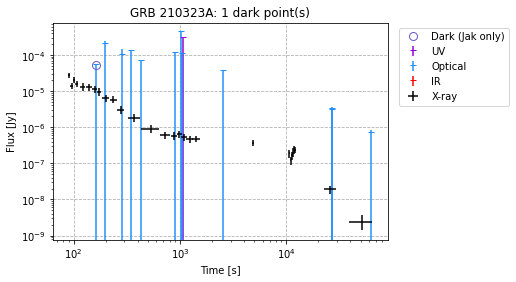

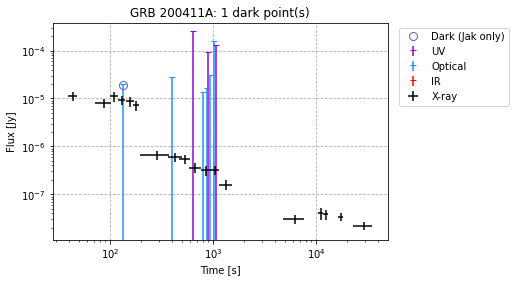

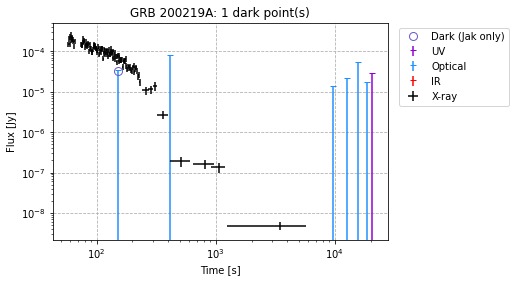

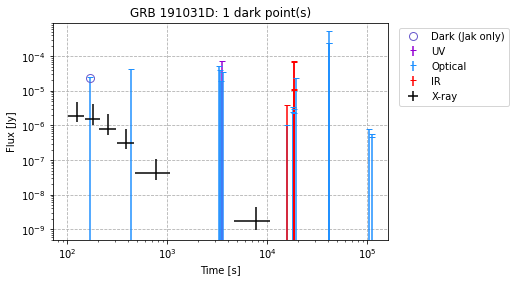

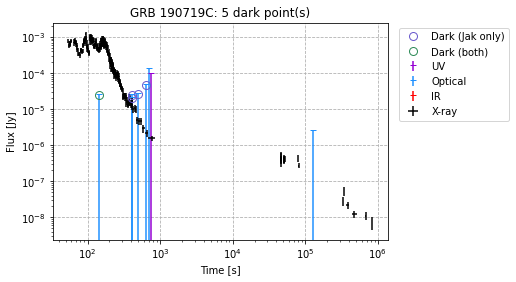

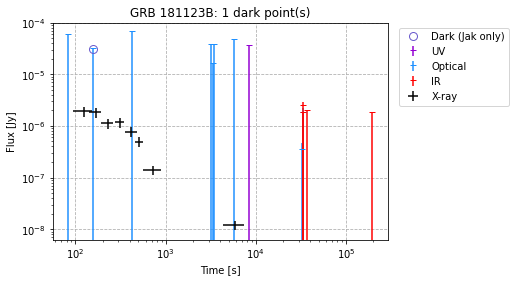

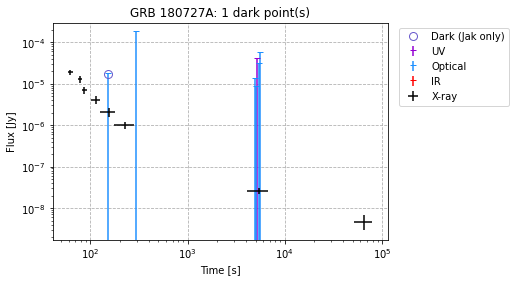

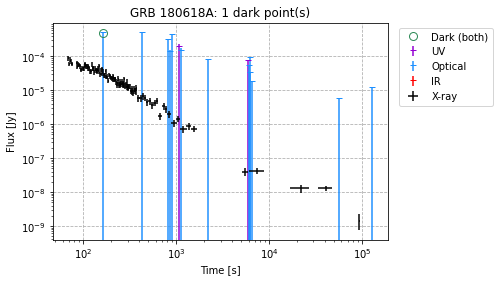

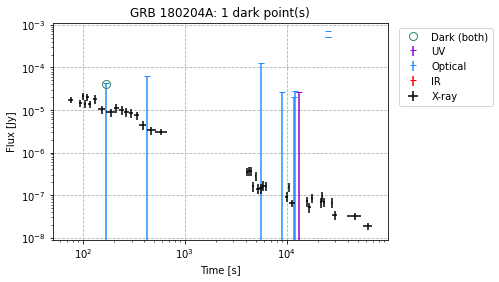

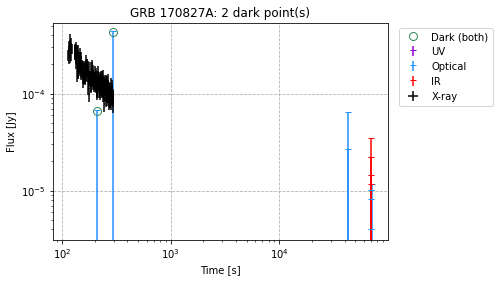

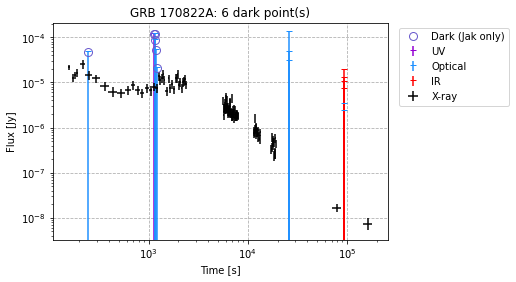

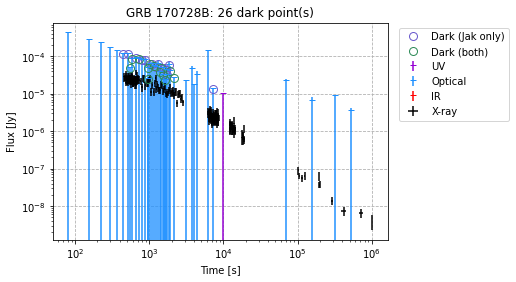

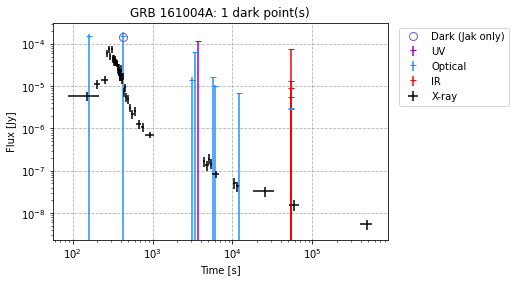

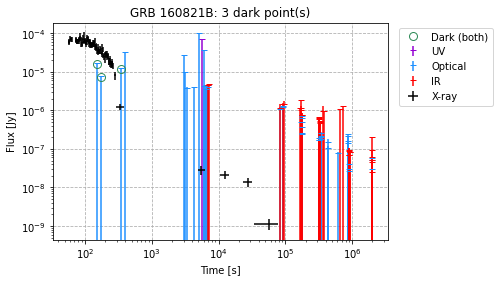

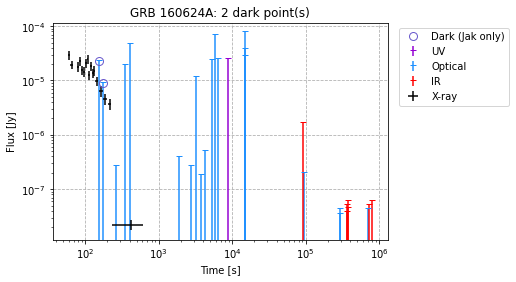

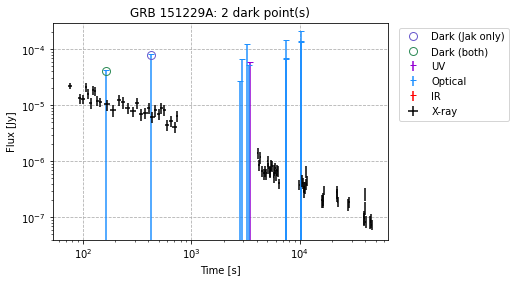

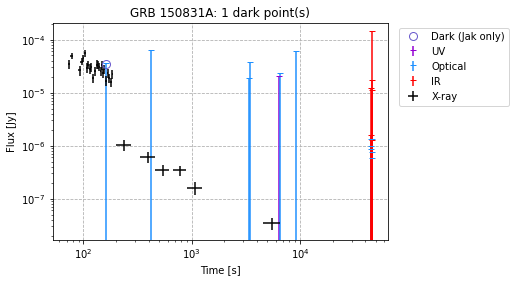

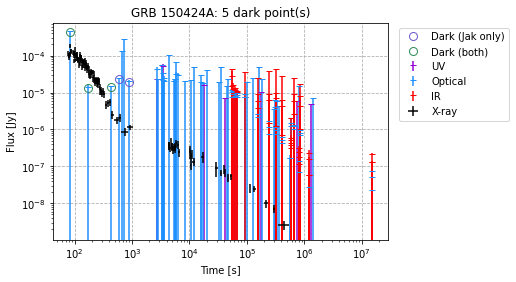

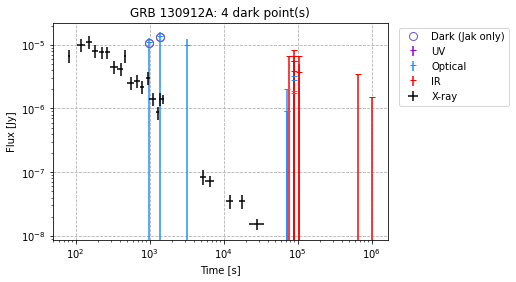

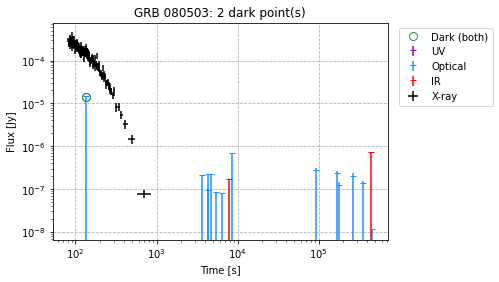

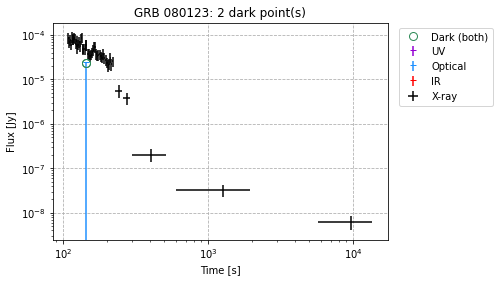

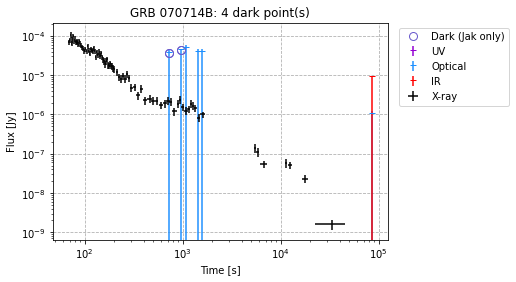

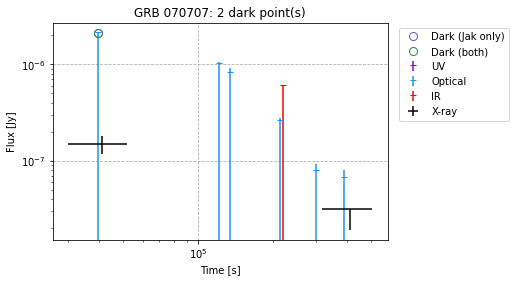

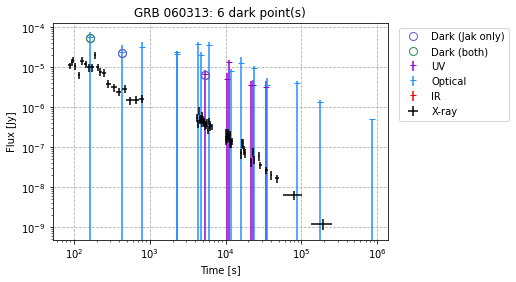

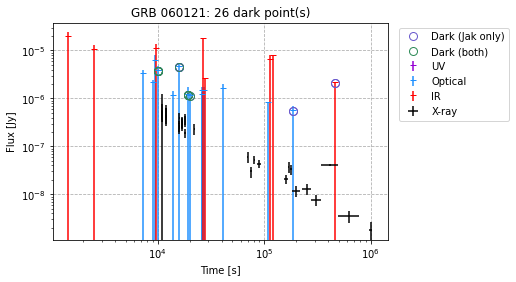

In [182]:
for grb in close_times["GRB"].unique():
    fig, ax = plt.subplots()

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times[close_times["GRB"]==grb]

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="$—$",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                          xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                          linestyle="",capthick=0,color="k",label="X-ray")
    
    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
            marker="o",markersize=8,mfc="none",mec="slateblue",
            linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
            marker="o",markersize=8,mfc="none",mec="goldenrod",
            linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
            marker="o",markersize=8,mfc="none",mec="seagreen",
            linestyle="",label="Dark (both)")
    
    ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1))
    ax.grid(linestyle="--")
    
    plt.title("GRB "+grb+": "+str(close_times["GRB"].tolist().count(grb))+" dark point(s)")
    #fig.savefig(f"./products/dark lightcurves/{grb}.png",dpi=300,bbox_inches="tight")
    plt.show()

## Population statistics

### Spectral index distributions

In [183]:
b_ox = [b.value for b in darkest_times["B_ox"]]
oxplus = [0.3*v.value if np.isinf(v.plus) else v.plus for v in darkest_times["B_ox"]]
oxminus = [0.3*v.value if np.isinf(v.minus) else v.minus for v in darkest_times["B_ox"]]
oxuplims = [err==np.inf for err in oxminus]
b_x = [b.value for b in darkest_times["B_x"]]
xplus = [0.3*v.value if np.isinf(v.plus) else v.plus for v in darkest_times["B_x"]]
xminus = [0.3*v.value if np.isinf(v.minus) else v.minus for v in darkest_times["B_x"]]
xuplims = [err==np.inf for err in xminus]

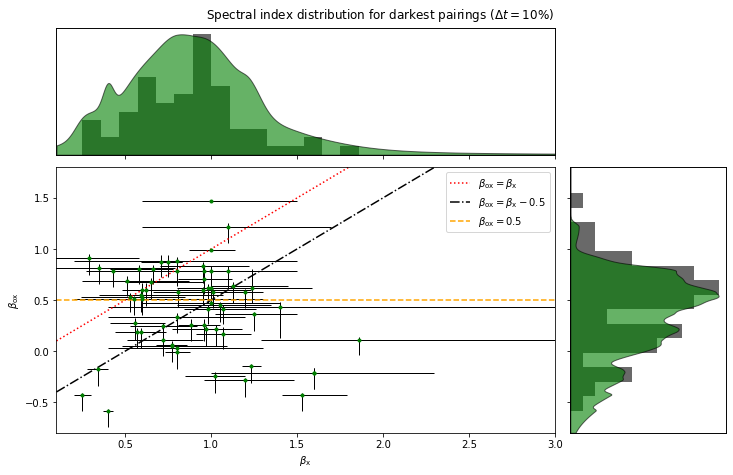

In [184]:
fig = plt.figure(figsize=(12,10))
grid = plt.GridSpec(4, 4, hspace=0.1, wspace=0.1)

ax_main = fig.add_subplot(grid[1:-1, 0:-1])
ax_right = fig.add_subplot(grid[1:-1, -1], xticklabels=[], yticklabels=[])
ax_top = fig.add_subplot(grid[0, 0:-1], xticklabels=[], yticklabels=[])

x = np.linspace(0.1,3,500)
y = np.linspace(-.8,1.8,500)

ax_main.errorbar(b_x,b_ox,xerr=[xminus,xplus],yerr=[oxminus,oxplus],uplims=oxuplims,xuplims=xuplims,linestyle="",marker=".",
                 mfc="g",mec="g",ecolor="k",elinewidth=1,capthick=4)
ax_main.plot(x,x,"r:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
ax_main.plot(x,x-.5,"k-.",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
ax_main.plot(x,[.5]*len(x),linestyle="--",color="orange",label=r"$\beta_\mathrm{ox}=0.5$")
ax_main.set(xlim=(x.min(),x.max()),ylim=(y.min(),y.max()),
            xlabel=r"$\beta_\mathrm{x}$",ylabel=r"$\beta_\mathrm{ox}$")
ax_main.legend()

# kde = stats.gaussian_kde(pd.Series(b_x)[pd.notna(b_x)])
# density = kde.evaluate(x)
ax_kde_x = ax_top.twinx()
valid_bx = darkest_times.loc[[bx.__isfinite__() for bx in darkest_times["B_x"]],"B_x"]
ax_kde_x.fill_between(x,np.sum([bx.pdf(x) for bx in valid_bx],axis=0),facecolor="green",edgecolor="k",alpha=.6)
ax_kde_x.set_ylim(0)
ax_kde_x.set_yticks([])
ax_top.hist(b_x,15,orientation='vertical', color="dimgrey")
ax_top.set_yticks([])
ax_top.set_xlim(ax_main.get_xlim())

# kde = stats.gaussian_kde(pd.Series(b_ox)[pd.notna(b_x)])
# density = kde.evaluate(y)
ax_kde_y = ax_right.twiny()
valid_box = darkest_times.loc[[box.__isfinite__() for box in darkest_times["B_ox"]],"B_ox"]
ax_kde_y.fill_betweenx(y,np.sum([box.pdf(y) for box in valid_box],axis=0),facecolor="green",edgecolor="k",alpha=.6)
ax_kde_y.set_xlim(0)
ax_kde_y.set_xticks([])
ax_right.hist(b_ox, 26, orientation='horizontal', color="dimgrey")
ax_right.set_xticks([])
ax_right.set_ylim(ax_main.get_ylim())


fig.suptitle(r"Spectral index distribution for darkest pairings ($\Delta t={}$%)".format(int(max_dt*100)), y=0.91)

plt.show()

### $N_H$ comparison

In [39]:
for i in sGRBs.index:
    grb = sGRBs.loc[i,"GRB"]
    print(grb, end=" ")
    try:
        sGRBs.loc[i,"N_H (intrinsic)"] = get_columnDensity(grb,swift)
        print(sGRBs.loc[i,"N_H (intrinsic)"])

    except:
        print("failed")

210726A 3.2e+21 (+1.3e+21, -1.1999999999999997e+21)
210413B failed
210410A 2.6e+20 (+5.9e+20, -2.6e+20)
210323A 1.7e+21 (+1e+21, -9e+20)
210119A failed
201221D failed
201214B failed
201006A 1.3e+23 (+5.9e+23, -4e+22)
200907B 1.6e+21 (+3.1e+21, -1.6e+21)
200826A failed
200716C failed
200623A failed
200522A failed
200411A 1.3e+21 (+8e+20, -7e+20)
200405B failed
200325A failed
200219A failed
191031D failed
190719C 6.8e+20 (+1.02e+21, -6.8e+20)
190627A 1.7e+21 (+6.099999999999999e+21, -1.7e+21)
190610A failed
190427A failed
190326A failed
181126A 7.7e+21 (+1.14e+22, -6.7e+21)
181123B 7e+20 (+3e+21, -7e+20)
180805B 8e+20 (+7e+20, -6e+20)
180805A failed
180727A 1.7e+21 (+1.8e+21, -1.4e+21)
180718A failed
180715A failed
180618A 2.6e+21 (+9.999999999999999e+20, -9e+20)
180418A 4e+19 (+7.3e+20, -4e+19)
180402A 9.199999999999999e+20 (+2.3199999999999997e+21, -9.199999999999999e+20)
180204A 5.8e+21 (+1.6e+21, -1.4e+21)
171103A failed
170827A failed
170822A 1.3e+21 ± 4e+20
170728B 2.08e+21 (+3.1e+

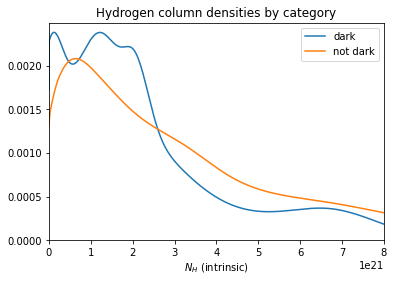

In [117]:
dark_nh = sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
notdark_nh = sGRBs.loc[~sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
max_x = 8e21
x = np.linspace(0.1,max_x,1000)
plt.plot(x,np.sum([nh.pdf(x) for nh in dark_nh],axis=0)/np.sum([nh.pdf(x) for nh in dark_nh]),label="dark")
plt.plot(x,np.sum([nh.pdf(x) for nh in notdark_nh],axis=0)/np.sum([nh.pdf(x) for nh in notdark_nh]),label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Hydrogen column densities by category")
plt.savefig("./products/NH_dists.png",dpi=300,bbox_inches="tight",facecolor="white",transparent=False)

In [42]:
stats.ks_2samp(sGRBs.loc[~sGRBs["GRB"].isin(dark["GRB"]), "N_H (intrinsic)"], sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]), "N_H (intrinsic)"], )

KstestResult(statistic=0.32, pvalue=0.01825734091979958)

### Observation depth over time

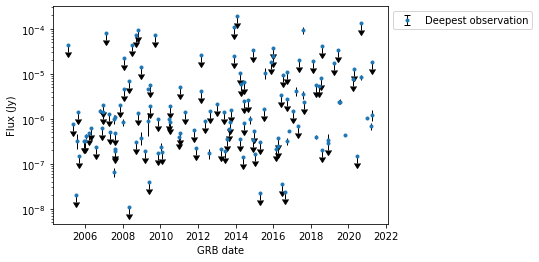

In [43]:
fig = plt.figure()
datestamps = []
deepests = []
for grb,opt in all_optical.dropna(subset=["Flux (Jy)"]).groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
    deepest_obs = min(opt["Flux (Jy)"])
    if pd.notna(deepest_obs):
        datestamps.append(mm+"/"+dd+"/20"+yy)
        deepests.append(deepest_obs)
datestamps = pd.to_datetime(datestamps)
vals = [v.value for v in deepests]
pos = [0.3*v.value if np.isinf(v.plus) else v.plus for v in deepests]
neg = [0.3*v.value if np.isinf(v.minus) else v.minus for v in deepests]
plt.errorbar(datestamps,[d.value for d in deepests],yerr=(neg,pos),linestyle="",marker=".",
             ecolor="k",elinewidth=1,label="Deepest observation",
             uplims=[np.isinf(point.minus) for point in deepests],
                lolims=[np.isinf(point.plus) for point in deepests],capsize=0)
#plt.plot(df.Date,df.Value,":",label=r"Log regression (R$^2=%.2f$)"%(r*r))
plt.yscale("log")
plt.ylabel("Flux (Jy)")
plt.xlabel("GRB date")
plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.show()
fig.savefig("./products/deepest_over_time.png",bbox_inches="tight",dpi=300)

## Illustrative example plot

GRB                                                 160624A
t_o                                                     152
dt%                                               0.0691522
nu_o                                            7.71532e+14
F_o                     2.2469077263974652e-05 (+0.0, -inf)
nu_x                                            4.18808e+17
F_x           6.43563651729827e-06 ± 1.4683568734923836e-06
B_ox        0.1985597727235074 (+0.03610621145682231, -inf)
B_x                                     0.77 (+0.32, -0.29)
Jak_dark                                               True
vdH_dark                                              False
Name: 812, dtype: object

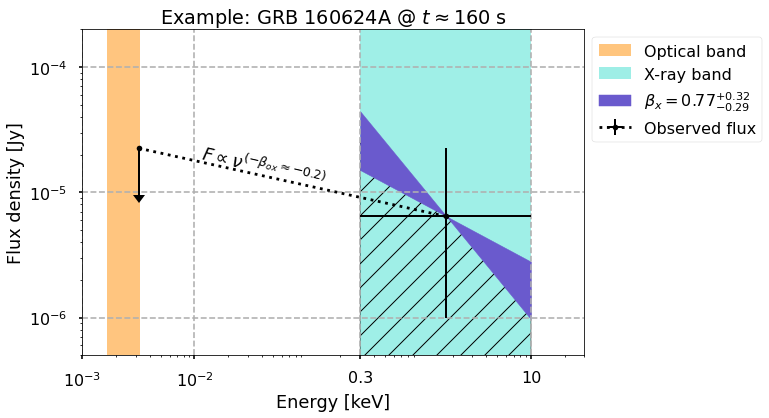

In [36]:
display(results[results["GRB"]=="160624A"].iloc[3,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)
beta = results.loc[812,"B_x"]
E_o = results.loc[812,"nu_o"]*6.62607015e-34/1.6021773e-16
E_x = results.loc[812,"nu_x"]*6.62607015e-34/1.6021773e-16
F_o = results.loc[812,"F_o"]
F_x = results.loc[812,"F_x"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

plt.style.use("seaborn-poster")
fig,ax = plt.subplots(figsize=(9,6),facecolor="none")

plt.fill_between([0.003262755,0.0016531293],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
plt.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
plt.errorbar([E_o,E_x],[F_o.value,F_x.value],xerr=[(0,E_x-0.3),(0,10-E_x)],
             yerr=[(0.000013,F_x.value-1e-6),(0,F_o.value-F_x.value)],
             uplims=[1,0],capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
plt.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
plt.fill_between(E_range,spec1,spec2,color="slateblue",label="$\\beta_x=%.2f_{-%.2f}^{+%.2f}$" %(beta.value,beta.minus,beta.plus))
plt.text(1.1e-2,1.1e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-0.2})}$",size=18,rotation=-13)

plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.grid(linestyle="--")
plt.xlim(1e-3,30)
plt.ylim(5e-7,2e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.001,0.01,0.3,10])
plt.gca().set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
plt.title(r"Example: GRB 160624A @ $t\approx160$ s")
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density [Jy]")
fig.savefig("./products/160624A.png",bbox_inches="tight",dpi=300)

## To-do

- classify individual cases: early-time obs., something else?
- incorporate $\Delta\beta_{ox}$
- compare $\beta_x$ distributions between vdH/Jakobsson dark bursts
    - dark between each method
    - dark vs non-dark for each method
- population statistics
    - x number of sGRBs, x have optical observations, x are dark
- for dark but have optical detections, estimate extinctions ($A_v$)
    - if $\beta_x = \beta_{ox}$ (straight spectrum)
    - if it is -0.5 (assumed dark)
- $N_H$ vs. $\beta_{ox}$ plot and vs. $A_v$
- distribution of $N_H$: are dark mostly at the high end?
- deepest observation of each GRB over time -- have we gotten better at chasing them?
    - some indicator of how early we catch them?
    - at what time are GRBs dark?
- play with $\alpha$, play with how to add $\Delta$ errors
- sum distributions and plot with hists
- count number of good observations per burst over time